# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [30]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

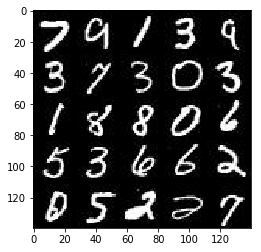

In [31]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

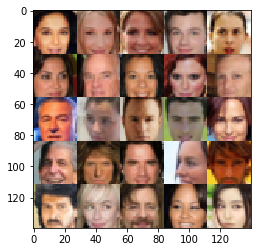

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [34]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [35]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # size of input layer = 24 x 24 x 3
        
        # 1st convolution layer 14 x 14 x 64
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        
        # 2nd convolution layer 7 x 7 x 128 with batch normalization 
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # 3rd convolution layer 4 x 4 x 256 with batch normalization
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        # Flatten - sigmoid activation 
        flat = tf.reshape(relu3, (-1, 4096))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def leaky_relu(x, alpha=0.1, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
   
    with tf.variable_scope('generator', reuse = not is_train):
        
        x1 = tf.reshape(tf.layers.dense(z, 4*4*256), (-1,4,4,256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        x1 = tf.nn.dropout(x1, 0.90)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=3, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        x2 = tf.nn.dropout(x2, 0.90)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        x3 = tf.nn.dropout(x3, 0.90)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='valid')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learning_rate_t = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    i = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):  
                # TODO: Train Model
                
                i += 1
                
                # Random noise to be passed into the Generator
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                if data_image_mode == 'RGB':
                    batch_images *= 2.0
                
                # Running optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z:batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, input_real: batch_images})
                
                if i%10 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if i%100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.1584... Generator Loss: 7.8319
Epoch 1/2... Discriminator Loss: 0.5587... Generator Loss: 3.1149
Epoch 1/2... Discriminator Loss: 0.5555... Generator Loss: 2.3931
Epoch 1/2... Discriminator Loss: 0.9597... Generator Loss: 2.4883
Epoch 1/2... Discriminator Loss: 0.6841... Generator Loss: 3.6181
Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 0.8828
Epoch 1/2... Discriminator Loss: 0.6821... Generator Loss: 1.4348
Epoch 1/2... Discriminator Loss: 0.5216... Generator Loss: 3.0943
Epoch 1/2... Discriminator Loss: 0.6240... Generator Loss: 2.7631
Epoch 1/2... Discriminator Loss: 2.0906... Generator Loss: 6.6703


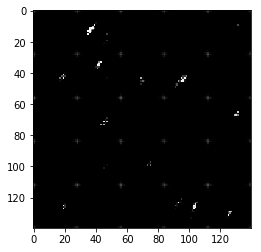

Epoch 1/2... Discriminator Loss: 0.9714... Generator Loss: 3.0600
Epoch 1/2... Discriminator Loss: 0.6200... Generator Loss: 2.3124
Epoch 1/2... Discriminator Loss: 0.3768... Generator Loss: 3.9484
Epoch 1/2... Discriminator Loss: 0.3470... Generator Loss: 4.7958
Epoch 1/2... Discriminator Loss: 0.3428... Generator Loss: 5.3968
Epoch 1/2... Discriminator Loss: 0.3479... Generator Loss: 5.5357
Epoch 1/2... Discriminator Loss: 0.3385... Generator Loss: 5.7037
Epoch 1/2... Discriminator Loss: 0.3777... Generator Loss: 3.4467
Epoch 1/2... Discriminator Loss: 0.3340... Generator Loss: 6.1285
Epoch 1/2... Discriminator Loss: 0.3337... Generator Loss: 6.3399


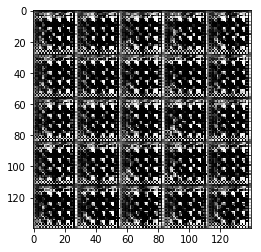

Epoch 1/2... Discriminator Loss: 0.3364... Generator Loss: 5.3556
Epoch 1/2... Discriminator Loss: 5.6454... Generator Loss: 0.0121
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.8374
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 1.1451
Epoch 1/2... Discriminator Loss: 0.6009... Generator Loss: 1.9495
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 1.0998
Epoch 1/2... Discriminator Loss: 2.0647... Generator Loss: 0.2465
Epoch 1/2... Discriminator Loss: 1.9587... Generator Loss: 0.2905
Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 3.3099
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 0.8754


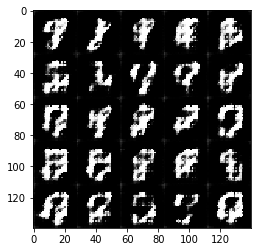

Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 3.5467
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 1.1762
Epoch 1/2... Discriminator Loss: 0.4065... Generator Loss: 3.1934
Epoch 1/2... Discriminator Loss: 0.3972... Generator Loss: 3.2638
Epoch 1/2... Discriminator Loss: 0.4420... Generator Loss: 2.5635
Epoch 1/2... Discriminator Loss: 0.4148... Generator Loss: 2.7856
Epoch 1/2... Discriminator Loss: 0.4001... Generator Loss: 2.8940
Epoch 1/2... Discriminator Loss: 0.4049... Generator Loss: 7.8477
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.1713


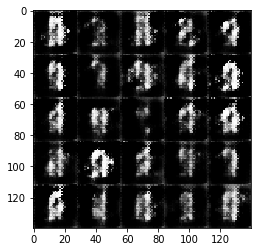

Epoch 1/2... Discriminator Loss: 0.4231... Generator Loss: 2.8182
Epoch 1/2... Discriminator Loss: 0.5614... Generator Loss: 3.0716
Epoch 1/2... Discriminator Loss: 0.5272... Generator Loss: 2.5105
Epoch 1/2... Discriminator Loss: 0.4888... Generator Loss: 2.5246
Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 1.6917
Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 1.3142
Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 1.6965
Epoch 1/2... Discriminator Loss: 0.7459... Generator Loss: 1.5569
Epoch 1/2... Discriminator Loss: 0.5555... Generator Loss: 3.1928
Epoch 1/2... Discriminator Loss: 0.6304... Generator Loss: 2.5344


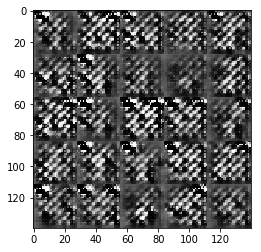

Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.5590
Epoch 1/2... Discriminator Loss: 0.8151... Generator Loss: 2.0063
Epoch 1/2... Discriminator Loss: 0.7630... Generator Loss: 1.5111
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 1.1051
Epoch 1/2... Discriminator Loss: 2.4603... Generator Loss: 5.6672
Epoch 1/2... Discriminator Loss: 0.7684... Generator Loss: 3.4317
Epoch 1/2... Discriminator Loss: 0.7496... Generator Loss: 2.1313
Epoch 1/2... Discriminator Loss: 3.2619... Generator Loss: 0.0867
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 1.0394
Epoch 1/2... Discriminator Loss: 0.8395... Generator Loss: 2.3244


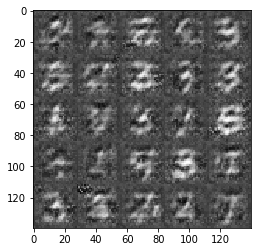

Epoch 1/2... Discriminator Loss: 2.2995... Generator Loss: 0.1989
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 1.7123
Epoch 1/2... Discriminator Loss: 2.1879... Generator Loss: 3.3621
Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 1.5811
Epoch 1/2... Discriminator Loss: 0.7243... Generator Loss: 3.7224
Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 1.1735
Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 2.6115
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 3.7263
Epoch 1/2... Discriminator Loss: 0.7242... Generator Loss: 2.8769


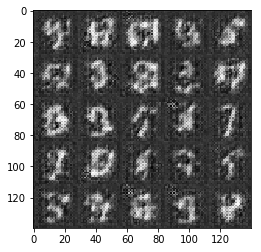

Epoch 1/2... Discriminator Loss: 1.5957... Generator Loss: 0.4077
Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 1.7452
Epoch 1/2... Discriminator Loss: 0.4411... Generator Loss: 2.6062
Epoch 1/2... Discriminator Loss: 1.0702... Generator Loss: 2.2761
Epoch 1/2... Discriminator Loss: 0.7022... Generator Loss: 1.4697
Epoch 1/2... Discriminator Loss: 0.4598... Generator Loss: 5.4240
Epoch 1/2... Discriminator Loss: 2.4785... Generator Loss: 3.4356
Epoch 1/2... Discriminator Loss: 1.0557... Generator Loss: 1.0159
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 2.8819
Epoch 1/2... Discriminator Loss: 1.7014... Generator Loss: 2.0534


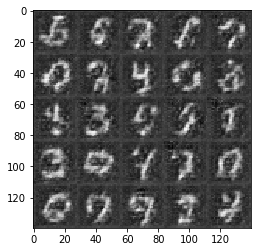

Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.7472
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 1.8722
Epoch 1/2... Discriminator Loss: 0.8799... Generator Loss: 1.0425
Epoch 1/2... Discriminator Loss: 0.7023... Generator Loss: 1.5416
Epoch 1/2... Discriminator Loss: 2.2205... Generator Loss: 4.1009
Epoch 1/2... Discriminator Loss: 0.6787... Generator Loss: 3.1451
Epoch 1/2... Discriminator Loss: 1.6236... Generator Loss: 2.3683
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 2.5134
Epoch 1/2... Discriminator Loss: 0.5590... Generator Loss: 3.9028
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 3.0586


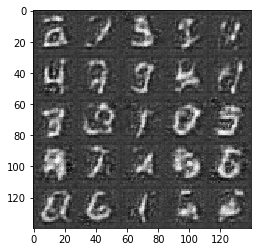

Epoch 1/2... Discriminator Loss: 0.8489... Generator Loss: 4.4347
Epoch 1/2... Discriminator Loss: 1.1808... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 0.5897... Generator Loss: 1.9861
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 3.0621
Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 3.5567
Epoch 2/2... Discriminator Loss: 0.5623... Generator Loss: 1.8103
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 1.3899
Epoch 2/2... Discriminator Loss: 0.8652... Generator Loss: 1.0303
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 2.3198
Epoch 2/2... Discriminator Loss: 0.5219... Generator Loss: 2.9902


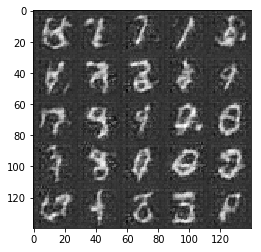

Epoch 2/2... Discriminator Loss: 0.3678... Generator Loss: 4.3590
Epoch 2/2... Discriminator Loss: 0.4642... Generator Loss: 6.7272
Epoch 2/2... Discriminator Loss: 0.3482... Generator Loss: 4.8484
Epoch 2/2... Discriminator Loss: 1.5980... Generator Loss: 0.5071
Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.5542
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 2.6142
Epoch 2/2... Discriminator Loss: 0.5902... Generator Loss: 2.6265
Epoch 2/2... Discriminator Loss: 0.7451... Generator Loss: 1.3185
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.6305
Epoch 2/2... Discriminator Loss: 0.6490... Generator Loss: 1.7241


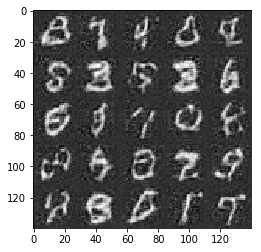

Epoch 2/2... Discriminator Loss: 0.5597... Generator Loss: 2.4031
Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 1.7401
Epoch 2/2... Discriminator Loss: 0.3581... Generator Loss: 4.4823
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 1.1235
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 0.3748... Generator Loss: 4.6476
Epoch 2/2... Discriminator Loss: 0.5133... Generator Loss: 1.9878
Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 1.2555
Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 1.1787
Epoch 2/2... Discriminator Loss: 0.4798... Generator Loss: 2.5931


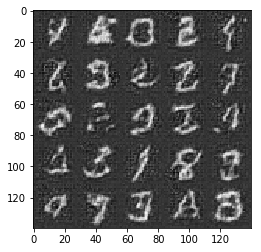

Epoch 2/2... Discriminator Loss: 0.3790... Generator Loss: 4.1255
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 1.2667
Epoch 2/2... Discriminator Loss: 0.4898... Generator Loss: 2.0654
Epoch 2/2... Discriminator Loss: 2.0949... Generator Loss: 0.3474
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.1739
Epoch 2/2... Discriminator Loss: 0.4448... Generator Loss: 2.9944
Epoch 2/2... Discriminator Loss: 0.4551... Generator Loss: 2.4178
Epoch 2/2... Discriminator Loss: 0.6068... Generator Loss: 1.5903
Epoch 2/2... Discriminator Loss: 1.6907... Generator Loss: 0.4285
Epoch 2/2... Discriminator Loss: 0.5972... Generator Loss: 1.8208


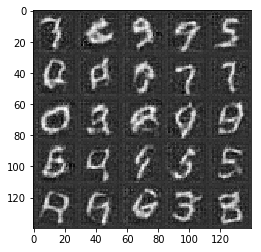

Epoch 2/2... Discriminator Loss: 0.7450... Generator Loss: 1.2523
Epoch 2/2... Discriminator Loss: 0.9030... Generator Loss: 2.2354
Epoch 2/2... Discriminator Loss: 0.4652... Generator Loss: 3.1133
Epoch 2/2... Discriminator Loss: 0.3773... Generator Loss: 3.3896
Epoch 2/2... Discriminator Loss: 0.4461... Generator Loss: 3.6793
Epoch 2/2... Discriminator Loss: 0.4402... Generator Loss: 2.7183
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 3.3015
Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 4.3292
Epoch 2/2... Discriminator Loss: 0.3937... Generator Loss: 3.1125
Epoch 2/2... Discriminator Loss: 0.3718... Generator Loss: 3.8284


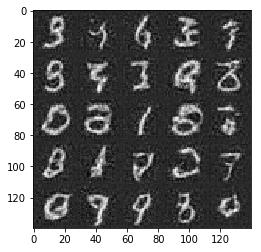

Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 1.7752
Epoch 2/2... Discriminator Loss: 1.2193... Generator Loss: 0.7898
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 2.2234
Epoch 2/2... Discriminator Loss: 0.4229... Generator Loss: 2.7403
Epoch 2/2... Discriminator Loss: 0.4017... Generator Loss: 3.8413
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 5.1895
Epoch 2/2... Discriminator Loss: 0.8322... Generator Loss: 2.3671
Epoch 2/2... Discriminator Loss: 0.5237... Generator Loss: 2.2476
Epoch 2/2... Discriminator Loss: 0.3793... Generator Loss: 3.6545
Epoch 2/2... Discriminator Loss: 0.4937... Generator Loss: 5.3971


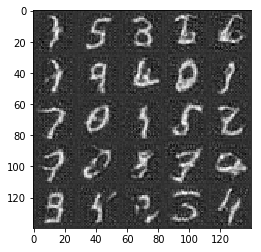

Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 0.8534
Epoch 2/2... Discriminator Loss: 0.5307... Generator Loss: 2.0681
Epoch 2/2... Discriminator Loss: 0.4217... Generator Loss: 3.3752
Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 3.2260
Epoch 2/2... Discriminator Loss: 0.4717... Generator Loss: 2.3375
Epoch 2/2... Discriminator Loss: 0.3988... Generator Loss: 4.5703
Epoch 2/2... Discriminator Loss: 0.4614... Generator Loss: 3.4748
Epoch 2/2... Discriminator Loss: 0.4484... Generator Loss: 2.2970
Epoch 2/2... Discriminator Loss: 0.3533... Generator Loss: 4.3596
Epoch 2/2... Discriminator Loss: 0.3606... Generator Loss: 4.3789


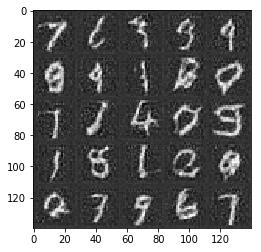

Epoch 2/2... Discriminator Loss: 0.3604... Generator Loss: 3.7081
Epoch 2/2... Discriminator Loss: 0.3478... Generator Loss: 5.4390
Epoch 2/2... Discriminator Loss: 0.3690... Generator Loss: 4.1802
Epoch 2/2... Discriminator Loss: 0.3636... Generator Loss: 3.4622
Epoch 2/2... Discriminator Loss: 0.3750... Generator Loss: 3.5367
Epoch 2/2... Discriminator Loss: 0.3819... Generator Loss: 5.3268
Epoch 2/2... Discriminator Loss: 2.2520... Generator Loss: 0.3527
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.0012
Epoch 2/2... Discriminator Loss: 0.6246... Generator Loss: 1.9896
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 1.9196


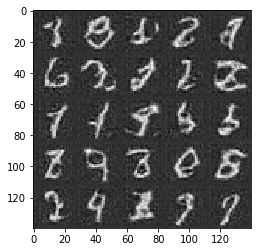

Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 2.8464
Epoch 2/2... Discriminator Loss: 0.4112... Generator Loss: 3.0052
Epoch 2/2... Discriminator Loss: 0.3693... Generator Loss: 4.2876
Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 2.6226
Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 1.9454
Epoch 2/2... Discriminator Loss: 0.6389... Generator Loss: 1.9309
Epoch 2/2... Discriminator Loss: 0.6058... Generator Loss: 1.9771
Epoch 2/2... Discriminator Loss: 0.4654... Generator Loss: 2.6011
Epoch 2/2... Discriminator Loss: 0.4052... Generator Loss: 3.1244
Epoch 2/2... Discriminator Loss: 0.4128... Generator Loss: 3.3897


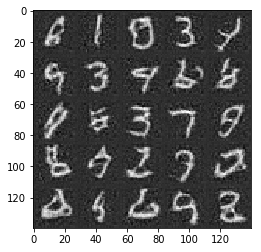

Epoch 2/2... Discriminator Loss: 0.4935... Generator Loss: 3.7863
Epoch 2/2... Discriminator Loss: 0.5757... Generator Loss: 2.0829
Epoch 2/2... Discriminator Loss: 0.5810... Generator Loss: 1.7523
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 1.2214
Epoch 2/2... Discriminator Loss: 0.4875... Generator Loss: 2.7987
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 2.6051
Epoch 2/2... Discriminator Loss: 0.3669... Generator Loss: 3.6696


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

# CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 3.1029
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 4.6288
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 5.0743
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 3.5725
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 6.0051
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 5.4300
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 3.5559
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 4.8793
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 4.4562
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 7.8049


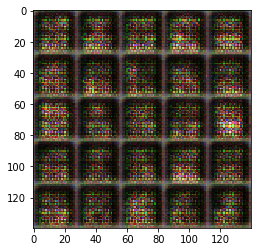

Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 3.5006
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 2.0250
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 1.3937
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 3.1887
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.6636
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 2.9711
Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 2.9702
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 4.0964
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 3.3912
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 4.2488


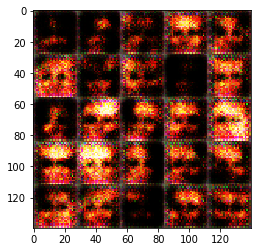

Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 3.9094
Epoch 1/1... Discriminator Loss: 0.3743... Generator Loss: 4.3481
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 2.7624
Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 4.0646
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 4.4523
Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 4.9222
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 7.4845
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 5.9578
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 4.7099
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 3.0605


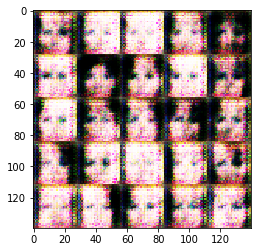

Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 5.2148
Epoch 1/1... Discriminator Loss: 0.3596... Generator Loss: 4.5079
Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 3.5269
Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 5.2912
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 5.6826
Epoch 1/1... Discriminator Loss: 0.3467... Generator Loss: 4.7055
Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 4.3719
Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 5.7941
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 4.5738
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 4.2241


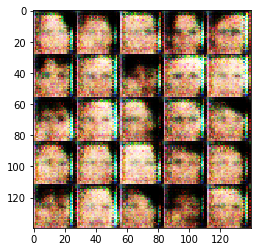

Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 7.4948
Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 4.6831
Epoch 1/1... Discriminator Loss: 0.3684... Generator Loss: 4.5415
Epoch 1/1... Discriminator Loss: 0.3617... Generator Loss: 4.3900
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 4.4788
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 8.6107
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 4.5314
Epoch 1/1... Discriminator Loss: 0.3772... Generator Loss: 4.2673
Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 4.8017
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 4.2197


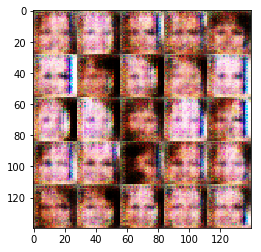

Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 3.4411
Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 2.6366
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 2.6537
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 3.7746
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 3.0188
Epoch 1/1... Discriminator Loss: 0.4154... Generator Loss: 3.0464
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 3.6268
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 4.5375
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 3.2992
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 3.4837


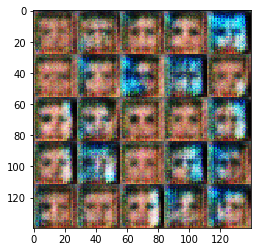

Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 3.7267
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 7.3736
Epoch 1/1... Discriminator Loss: 0.3778... Generator Loss: 4.2206
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 2.3053
Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 4.1009
Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 3.0672
Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 3.9035
Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 3.8056
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 3.7563
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 3.0489


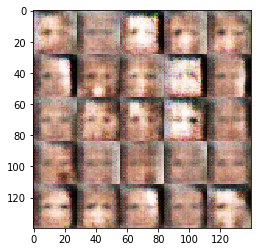

Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 4.9898
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 4.3121
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 2.1088
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 2.4355
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 3.2997
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 4.0452
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 4.1667
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 2.6205
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 3.5081
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 3.2681


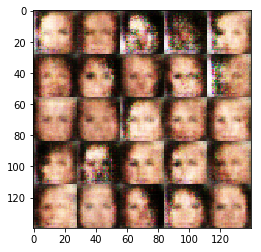

Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 3.9006
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 3.1161
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 3.2880
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 2.3103
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.8613
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 2.8079
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 2.6537
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 2.3911
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 3.9583
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 2.0577


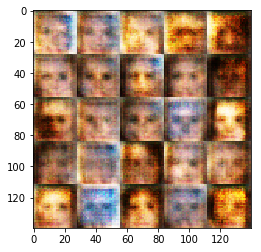

Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 3.0806
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 1.9681
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 2.6653
Epoch 1/1... Discriminator Loss: 0.4621... Generator Loss: 3.1426
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 2.9480
Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 3.2299
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.3297
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 2.2795
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 2.6772
Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 2.9908


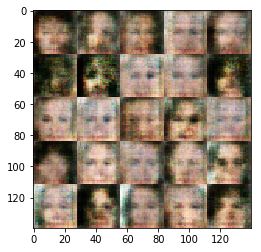

Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.5833
Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 2.1874
Epoch 1/1... Discriminator Loss: 0.5785... Generator Loss: 3.3100
Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 3.4550
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 2.8307
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 3.9843
Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 3.0977
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 3.4010
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 5.5020
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 2.3479


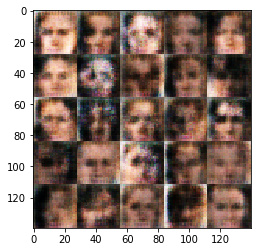

In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.